In [1]:
from typing import Dict
import argparse

parser = argparse.ArgumentParser(description='NeuMF')

parser.add_argument('--ratings_path', required=False, default='data/ml-1m/ratings.dat')
parser.add_argument('--emb_dim', required=False, default=64)
parser.add_argument('--neg_ratio', required=False, default=3)
parser.add_argument('--prep_data_dir', required=False, default='prep_data')
parser.add_argument('--prep_data_name', required=False, default='prep_data.pkl')
parser.add_argument('--test_ratio', required=False, default=0.1)
parser.add_argument('--batch_size', required=False, default=128)
parser.add_argument('--lr', required=False, default=0.01)
parser.add_argument('--n_epoch', required=False, default=30)
parser.add_argument('--train_test_split_rs', required=False, default=1234)
parser.add_argument('--topk', required=False, default=25)



def update_dataset_args(args, new_args:Dict):
    for new_arg, new_value in new_args.items():
        print(new_arg, new_value)
        args.new_arg = new_value
        for k, v in vars(args).items():
            print(f"{k:>20} : {v:<}")
    return args

args = parser.parse_args([])

In [2]:
from torch.utils.data import Dataset, DataLoader, random_split

# from arguments import args
from dataset.prepdataset import ML1mDataset
from dataset.customdataset import CustomTrainDataset, CustomTestDataset
from model import NeuMF
from trainer import Trainer

In [3]:
ml1m_dataset = ML1mDataset(args)
ml1m_dataset.preprocess()
train_dataset = CustomTrainDataset(args, ml1m_dataset)
test_dataset = CustomTestDataset(args, ml1m_dataset)
for k, v in vars(args).items():
    print(f"{k:>20} : {v:<}")

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

model = NeuMF(args)

Already exist preprocessed data=============================
prep_data_path : prep_data/prep_data.pkl
CustomTrainDataset Init=====================================
CustomTestDataset Init======================================
# of test users : 5959
        ratings_path : data/ml-1m/ratings.dat
             emb_dim : 64
           neg_ratio : 3
       prep_data_dir : prep_data
      prep_data_name : prep_data.pkl
          test_ratio : 0.1
          batch_size : 128
                  lr : 0.01
             n_epoch : 30
 train_test_split_rs : 1234
                topk : 25
              n_user : 6040
              n_item : 3706


In [4]:
# torch.save(model.state_dict(), 'result/neumf.pth')

In [5]:
import torch
model_path = 'result/neumf.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

NeuMF(
  (GMF_user): Embedding(6040, 64)
  (GMF_item): Embedding(3706, 64)
  (MLP_user): Embedding(6040, 64)
  (MLP_item): Embedding(3706, 64)
  (MLP_linear): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
  )
  (output_layer): Linear(in_features=72, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
from tqdm.auto import tqdm
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for user, item, label in tqdm(test_dataloader):
        logits = model(user, item)
        label = label.type(torch.FloatTensor)

        correct += torch.sum((logits.flatten()>=0.5) == label).item()
        total += len(label)
print(f"acc : {correct/total:.4f}")

  0%|          | 0/782 [00:00<?, ?it/s]

acc : 0.5160


In [12]:
len(one_test_user)

3706

In [44]:
test = ml1m_dataset.load_prep_data()['test']
from tqdm.auto import tqdm
model.eval()

actual_set_collect, pred_collect = [], []
with torch.no_grad():
    for user in list(test.keys()):
        one_test_user = [user] * args.n_item
        one_test_user = torch.LongTensor(one_test_user)
        test_items = list(range(args.n_item))
        test_items = torch.LongTensor(test_items)
        logits = model(one_test_user, test_items)
        pred = logits.flatten().numpy().argsort()[::-1][:args.topk]

        actual_set_collect.append(test[user])
        pred_collect.append(pred)


  0%|          | 0/5959 [00:00<?, ?it/s]

In [45]:
ndcg = NDCG(args.topk)

In [46]:
ndcg.cal_ndcg_batch(actual_set_collect, pred_collect)

In [47]:
ndcg.avg_ndcg

0.05879074843104349

In [48]:
ndcg.n_sample

5959

In [41]:
import numpy as np
class NDCG:
    def __init__(self, topk):
        self.topk = topk
        self.ndcg = []
        self.n_sample = 0
        self.avg_ndcg = 0

    def cal_ndcg_batch(self, actual_set, pred):
        assert len(actual_set) == len(pred)

        for i in range(len(actual_set)):
            ndcg = self.cal_ndcg_one_sample(actual_set[i], pred[i])
            self.ndcg.append(ndcg)
            self.n_sample += 1

        self.avg_ndcg = sum(self.ndcg) / self.n_sample

    def cal_ndcg_one_sample(self, actual_set, pred):
        # idcg
        cal_num = min(self.topk, len(actual_set))
        idcg = sum([1.0 / np.log2(i + 1) for i in range(1, cal_num+1)])

        # dcg
        dcg = 0
        for i, item in enumerate(pred, start=1):
            if item in actual_set:
                dcg += 1.0 / np.log2(i + 1)
        # ndcg
        ndcg = dcg / idcg
        return ndcg

In [51]:
logits[2426]

tensor([0.9968])

In [37]:
pred = logits.flatten().numpy().argsort()[::-1][:args.topk]
pred

array([2651, 1120, 2426, 3566, 1848,  466, 1106,  575,  346, 1466, 2203,
        579, 1173,   20,  106, 1788, 2708, 1774, 1167,  576, 1271,  737,
       1123, 1155, 2374])

In [38]:
test[user]

array([ 970, 2557,  639, 1154])

In [39]:
ndcg = NDCG(args.topk)

In [40]:
ndcg.cal_ndcg_one_sample(test[user], pred)

0.0

In [52]:
import time

In [53]:
time.time()

1671980951.611618

In [ ]:
# ndcg
ndcg_k = dcg / idcg
print(f"idcg : {idcg:.4f}, dcg : {dcg:.4f}, ndcg : {ndcg_k:.4f}")

idcg : 1.6309, dcg : 1.0616, ndcg : 0.6509


In [8]:
test_dataloader

In [7]:
for user in test_dataloader:
    break

In [8]:
user

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 128])

In [ ]:
u = test_users[0]

In [ ]:
prep_data = ml1m_dataset.load_prep_data()

In [ ]:
prep_data.keys()

dict_keys(['train', 'test', 'update_args'])

In [ ]:
torch.sum((logits.flatten()>=0.5) == label).item() / len

TypeError: unsupported operand type(s) for /: 'int' and 'builtin_function_or_method'

tensor(0.7841, grad_fn=<BinaryCrossEntropyBackward0>)

# nDCG

In [ ]:
import numpy as np
k=5
actual_set = set([3, 4])
idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(actual_set)))])
print(idcg)
# for i, r in enumerate(np.log(i+2)

2.352934267515801


In [ ]:
dcg = 0.0
def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

predicted = [3, 4]

In [ ]:
seen = set()

In [ ]:
[x for x in predicted if not (x in seen or seen.add(x))]


[3, 4]

In [ ]:
k = 5
actual_set = set([3, 4])
pred = [6, 3, 8, 4, 5]

In [ ]:
# idcg
cal_num = min(k, len(actual_set))
idcg = sum([1.0 / np.log2(i + 1) for i in range(1, cal_num+1)])
print(f"idcg : {idcg:.4f}")

idcg : 1.6309


In [ ]:
# dcg
dcg = 0
for i, item in enumerate(pred, start=1):
    if item in actual_set:
        dcg += 1.0 / np.log2(i + 1)

print(f"dcg : {dcg:.4f}")

dcg : 1.0616


In [ ]:
# ndcg
ndcg_k = dcg / idcg
print(f"idcg : {idcg:.4f}, dcg : {dcg:.4f}, ndcg : {ndcg_k:.4f}")

idcg : 1.6309, dcg : 1.0616, ndcg : 0.6509


Text(0.5, 1.0, "histogram of nn.Parameter(torch.Tensor(100, 32))'s weights. (# : 3200)")

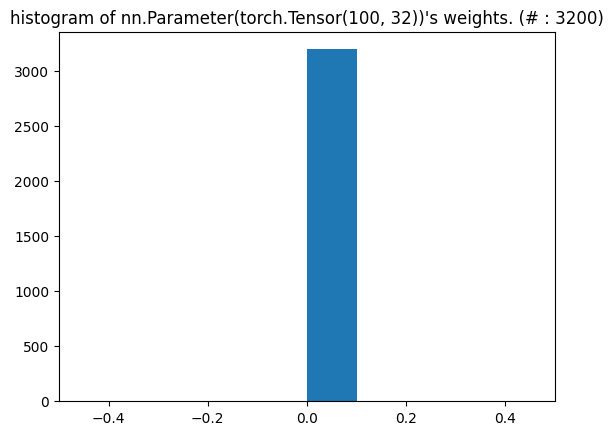

In [150]:
parameter = torch.nn.Parameter(torch.Tensor(100, 32))
import matplotlib.pyplot as plt
plt.hist(parameter.detach().numpy().reshape(-1))
plt.xlim(-0.5, 0.5)
plt.title("histogram of nn.Parameter(torch.Tensor(100, 32))'s weights. (# : 3200)")

Text(0.5, 1.0, "histogram of nn.Linear(100, 32)'s weight (# : 3200)")

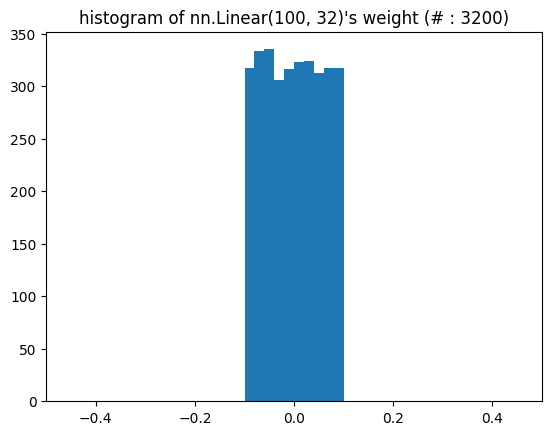

In [136]:
linear = torch.nn.Linear(100, 32)
import matplotlib.pyplot as plt
plt.hist(linear.weight.detach().numpy().reshape(-1))
plt.xlim(-0.5, 0.5)
# plt.ylim(0, 3500)
plt.title("histogram of nn.Linear(100, 32)'s weight (# : 3200)")

Text(0.5, 1.0, "histogram of nn.Embedding(100, 32)'s weight (# : 3200)")

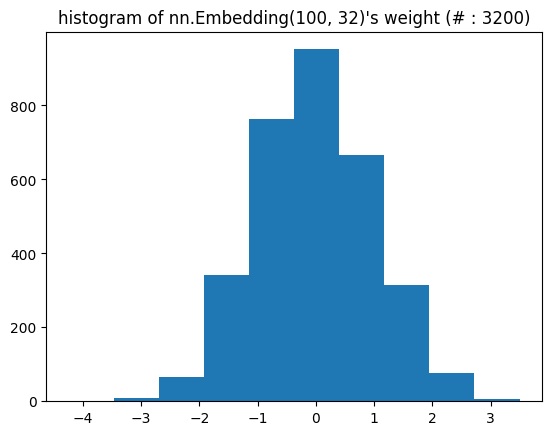

In [152]:
embedding = torch.nn.Embedding(100, 32)
import matplotlib.pyplot as plt
plt.hist(embedding.weight.detach().numpy().reshape(-1))
# plt.xlim(-0.5, 0.5)
# plt.ylim(0, 3500)
plt.title("histogram of nn.Embedding(100, 32)'s weight (# : 3200)")